In [0]:
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf



TensorFlow 2.x selected.


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
from google.colab import drive
import os
import json

drive.mount('/content/drive')
PATH = '/content/drive/My Drive/DL/pool/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data generator

In [0]:
import glob
import numpy as np
ind_mask = np.load(PATH + 'mask_all.npy')
ind_slide = np.load(PATH + 'slide_all.npy')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def get_multi_level_imgs(slide_name, levels=[0, 1, 3], width=128, height=128, x=0, y=0):
    """
    Given a slide or tumor mask, output multiple level images with the same shape (height and width).
    These images belong to multiple zoom levels, which is specified by the parameter levels, but with the same center point w.r.t. the whole slide.
    :param slide: A openslide.OpenSlide instance 
    :param levels: A list, specifying the zoom levels of which the users want to get the corresponding image. eg. [0, 1, 2], [0, 1, 3, 5] ...
    :param width, height: the expected width and height of each image to output 
    :param x, y: giving the top left pixel w.r.t. the biggest zoom level (i.e. the coarsest level) that the user specifies
    :return: a list of images corresponding to the different zoom levels that the user specified (from the finest to the coarsest)
    """
    x = int(x)
    y = int(y)
    slide_path = 'tumor_'+ slide_name +'.tif'

    slide = open_slide(slide_path)
    
    assert len(levels)>0
    levels.sort()
    finest = levels[0]
    coarsest = levels[-1]
    assert 0 <= x <= slide.level_dimensions[coarsest][0] - width
    assert 0 <= y <= slide.level_dimensions[coarsest][1] - height

    result_imgs = []
    for level in levels:
        x_temp = x*2**(coarsest-level) + (width*2**(coarsest-level) - width)/2
        y_temp = y*2**(coarsest-level) + (height*2**(coarsest-level) - height)/2

        img = read_slide(slide=slide, x=int(x_temp*2**level), y=int(y_temp*2**level), level=level, width=width, height=height)
        result_imgs.append(img)
    
    return np.concatenate((result_imgs[0], result_imgs[1], result_imgs[2]), axis=2)



In [0]:
print(len(ind_mask))
print(ind_mask[:5])
print(len(ind_slide))
print(ind_slide[:5])
X_slide = np.concatenate((ind_slide, ind_mask), axis=0)
print('len(X_slide): ', len(X_slide))

114161
['001_8672_16736' '001_8672_16752' '001_8688_15568' '001_8688_15584'
 '001_8688_15712']
2369154
['001_0_0' '001_0_16' '001_0_32' '001_0_48' '001_0_64']
len(X_slide):  2483315


In [0]:
import sklearn
from sklearn.model_selection import train_test_split

train, val = train_test_split(X_slide, random_state=42)
print('Length of training set: ',len(train))
train[0:5]

Length of training set:  1862486


array(['110_9184_4816', '019_5872_26976', '001_1424_10944',
       '031_8016_20496', '091_1968_4336'], dtype='<U32')

In [0]:
partition = {'train': train, 'validation': val}

labels = {}

for i in ind_mask:
    labels[i] = 1
for i in ind_slide:
    labels[i] = 0

assert len(labels) == len(ind_mask) + len(ind_slide)

print('label obtained successfully!')

label obtained successfully!


In [0]:
neg = 0
neg_train = []
pos = 0
pos_train = []

for i in train:
  if labels[i] == 1:
    pos += 1
    pos_train.append(i)
  elif labels[i] == 0:
    neg += 1
    neg_train.append(i)
  else:
    print('Error')


total = neg + pos
print('Training Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Training Examples:
    Total: 1862486
    Positive: 85592 (4.60% of total)



In [0]:
neg = 0
neg_val = []
pos = 0
pos_val = []

for i in val:
  if labels[i] == 1:
    pos += 1
    pos_val.append(i)
  elif labels[i] == 0:
    neg += 1
    neg_val.append(i)
  else:
    print('Error')


total = neg + pos
print('Validation Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Validation Examples:
    Total: 620829
    Positive: 28569 (4.60% of total)



In [0]:
# file_index_list = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', '064', '091', '096', '101', '110']
file_index_list = ['001']
for im_name in file_index_list:

  slide_path = 'tumor_'+ im_name +'.tif' # only this file is available
  tumor_mask_path = 'tumor_'+ im_name +'_mask.tif' # only this file is available


  slide_url = "https://storage.googleapis.com/dl4cv1445/ADL/tumor_"+ im_name +".tif"
  mask_url = "https://storage.googleapis.com/dl4cv1445/ADL/tumor_" + im_name + "_mask.tif"

  # Download the whole slide image
  if not os.path.exists(slide_path):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

max_level = min(slide.level_dimensions, tumor_mask.level_dimensions)

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(max_level)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                            slide.level_dimensions[i], 
                                                            slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_001.tif with width: 97792, height: 221184
Read tumor mask from tumor_001_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256


Sanity check: 

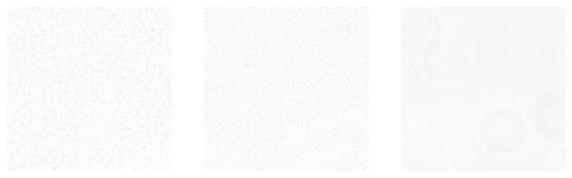

In [0]:
im_013 = get_multi_level_imgs('001', levels=[0, 1, 3], width=128, height=128, x=6000, y=4000)
# x: x_axis in level3 
# y: y_axis in level3

fig, axes = plt.subplots(1, 3, figsize=(10, 10*3))

for i in range(3):
  axes[i].imshow(im_013[..., i*3: (i+1)*3])
  axes[i].axis('off')

Create data generator

In [0]:
import random
from random import shuffle
from numpy import asarray
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dt_type, labels, batch_size=32, dim=(128,128), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dt_type = dt_type
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(20000/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        if self.dt_type == 'train':
            # Generate data
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_train))
              IDs.append(random.choice(neg_train))
            shuffle(IDs)
        elif self.dt_type == 'validation':
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_val))
              IDs.append(random.choice(neg_val))
            shuffle(IDs)

        # Generate data
        X, y = self.__data_generation(IDs)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
        gc.collect()

    def __data_generation(self, IDs):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        channels = 1
        X = np.empty((self.batch_size, *self.dim, self.n_channels*3))
        y = np.empty((self.batch_size), dtype=int)
        

        for i, ID in enumerate(IDs):
            # print("ID: ", ID)
            # Store sample
            slide_name = ID.split('_')[0]
            X[i,] = get_multi_level_imgs(slide_name, levels=[0, 1, 3], width=128, height=128, x=ID.split('_')[1], y=ID.split('_')[2])
            # convert image to numpy array
            X[i,] = asarray(X[i,])
            # if self.dt_type == 'train':
            #     # Data augmentation
            #     ro = random.randint(1, 5)
            #     if ro == 1:
            #       X[i,] = np.rot90(X[i,])
            #     if ro == 2:
            #       X[i,] = np.fliplr(X[i,])
            #     if ro == 3:
            #       X[i,] = np.flipud(X[i,])
            #     if ro == 4:
            #       X[i,] = np.rot90(X[i,], 2)

            X[i,] /= 255.0

            # Store class
            y[i] = self.labels[ID]
        return X, y

In [0]:
import numpy as np
import gc

from keras.models import Sequential
# from my_classes import DataGenerator

# Parameters
params = {'dim': (128,128),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator('train', labels, **params)
validation_generator = DataGenerator('validation', labels, **params)



Using TensorFlow backend.


# Level 3

## Define model

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model3 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='relu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)), 
  tf.keras.layers.Dense(
          64, activation='relu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='relu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



In [0]:
# rmsprop = RMSprop(lr=0.1)
# adam = tf.keras.optimizers.Adam(lr=0.01)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model3.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

# tf.keras.utils.plot_model(model3, show_shapes=True)

## Load model

In [0]:
import os
checkpoint_path = 'model_tumor_level3.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level3.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url

In [0]:
model3.load_weights('model_tumor_level3.h5')

In [0]:
# model3.save(PATH+'model_tumor_level3.h5')

In [0]:
desired_layer3 = model3.get_layer('dense_2').output

# Create the feature extraction model
desired3 = tf.keras.Model(inputs=model3.input, outputs=desired_layer3)

# Level 1

## Define model

In [0]:

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model1 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='elu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)),
  tf.keras.layers.Dense(
          128, activation='elu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(
          64, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model1.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

# tf.keras.utils.plot_model(model1, show_shapes=True)

## Load model

In [0]:
import os
checkpoint_path = 'model_tumor_level1.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level1.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url


In [0]:
model1.load_weights('model_tumor_level1.h5')

In [0]:
# model1.save(PATH + 'model_tumor_level1.h5')

In [0]:
desired_layer1 = model1.get_layer('dense_7').output

# Create the feature extraction model
desired1 = tf.keras.Model(inputs=model1.input, outputs=desired_layer1)

# Level 0

## Define model

In [0]:

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model0 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='elu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)),
  tf.keras.layers.Dense(
          128, activation='elu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(
          64, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model0.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

# tf.keras.utils.plot_model(model0, show_shapes=True)

## Load model

In [0]:
import os
checkpoint_path = 'model_tumor_level0.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level0.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url


In [0]:
model0.load_weights('model_tumor_level0.h5')

In [0]:
# model0.save(PATH + 'model_tumor_level0.h5')

In [0]:
desired_layer0 = model0.get_layer('dense_12').output

# Create the feature extraction model
desired0 = tf.keras.Model(inputs=model0.input, outputs=desired_layer0)

# Concatenation

In [0]:
PATH_models = '/content/drive/My Drive/DL/pool/'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d0 = desired0
    self.d1 = desired1
    self.d3 = desired3
    self.dense1 = Dense(48, activation='relu')
    self.dense2 = Dense(16, activation='relu')
    self.last = Dense(1, activation='sigmoid')

  def call(self, X):
    x0 = X[..., 0:3]
    x1 = X[..., 3:6]
    x3 = X[..., 0:3]
    a1 = self.d0(x0)
    a2 = self.d1(x1)
    a3 = self.d3(x3)
    # print('a1.shape: ', a1.shape)
    # print('a2.shape: ', a2.shape)
    # print('a3.shape: ', a3.shape)
    feat = tf.concat([a1, a2, a3], axis=1)
    feat = self.dense1(feat)
    feat = self.dense2(feat)
    return self.last(feat)

# Create an instance of the model
model = MyModel()

In [0]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.000001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(PATH_models+'model_tumor.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])


In [0]:
model.build(input_shape=(None, 128, 128, 9))

In [0]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 16)                19347472  
_________________________________________________________________
model_1 (Model)              (None, 16)                19347472  
_________________________________________________________________
model (Model)                (None, 16)                19077008  
_________________________________________________________________
dense_14 (Dense)             multiple                  2352      
_________________________________________________________________
dense_15 (Dense)             multiple                  784       
_________________________________________________________________
dense_16 (Dense)             multiple                  17        
Total params: 57,775,105
Trainable params: 57,087,937
Non-trainable params: 687,168
________________________________________

## Train on epoch

In [0]:
# i = 0
# batch_size = 32
# batch_features = np.zeros(shape=(batch_size, 128, 128, 9))
# batch_labels = np.zeros(shape=(batch_size))
# for inputs_batch, labels_batch in training_generator:
#     # features_batch = conv_base.predict(inputs_batch)
#     batch_features[0 : batch_size] = inputs_batch
#     batch_labels[0: batch_size] = labels_batch
#     if np.count_nonzero(batch_labels) > 1:
#       print('Found!')
#       break

# print(batch_features.shape, batch_labels.shape)

In [0]:
# epochs = 10
# for i in range(epochs):
#   metrics = model.train_on_batch(
#                   batch_features,
#                   y=batch_labels
#                   # class_weight=class_weight
#               )
#   print(i, ' epoch: ', metrics[0], metrics[1])


## Train all dataset

In [0]:
model.load_weights(PATH_models+'model_tumor.h5')

In [0]:
# EPOCHS = 20

# # Train model on dataset

# model_history = model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=False,
#                     workers=1, 
#                     epochs=EPOCHS,
#                     max_queue_size=6,
#                     callbacks=callbacks)

In [0]:
# try:
#   loss = np.load(PATH_models + 'loss.npy', loss)
#   val_loss = np.load(PATH_models + 'val_loss.npy', val_loss)
#   acc = np.load(PATH_models + 'acc.npy', acc)
#   val_acc = np.load(PATH_models + 'val_acc.npy', val_acc)
# except:
#   loss = []
#   val_loss = []

#   acc = []
#   val_acc = []


In [0]:
# loss = [0.5150, 0.5089, 0.5075, 0.5075, 0.5074, 0.5072, 0.5073, 0.5069, 0.5073, 0.5070, 0.5067, 0.5066, 0.5065, 0.5065, 0.5065, 0.5064, 0.5066, 0.5066, 0.5065, 0.5065, 0.5064, 0.5062]
# acc = [0.9744, 0.9861, 0.9893, 0.9890, 0.9892, 0.9898, 0.9896, 0.9904, 0.9895, 0.9902, 0.9910, 0.9912, 0.9913, 0.9915, 0.9915, 0.9916, 0.9912, 0.9913, 0.9916, 0.9913, 0.9918, 0.9923]

# val_loss = [0.5174, 0.5134, 0.5135, 0.5138, 0.5133, 0.5157, 0.5142, 0.5145, 0.5180, 0.5129, 0.5132, 0.5137, 0.5144, 0.5127, 0.5127, 0.5130, 0.5117, 0.5137, 0.5150, 0.5145, 0.5146, 0.5132]
# val_acc = [0.9632, 0.9738, 0.9721, 0.9706, 0.9727, 0.9778, 0.9706, 0.9706, 0.9709, 0.9741, 0.9749, 0.9720, 0.9703, 0.9750, 0.9749, 0.9745, 0.9769, 0.9721, 0.9680, 0.9707, 0.9697, 0.9743]

In [0]:
# loss += model_history.history['loss']
# val_loss += model_history.history['val_loss']

# acc += model_history.history['accuracy']
# val_acc += model_history.history['val_accuracy']


In [0]:
# np.save(PATH_models + 'loss.npy', loss)
# np.save(PATH_models + 'val_loss.npy', val_loss)
# np.save(PATH_models + 'acc.npy', acc)
# np.save(PATH_models + 'val_acc.npy', val_acc)

In [0]:
# epochs = range(len(loss))

# plt.figure()
# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss Value')
# # plt.ylim([0, 1])
# plt.legend()
# plt.show()

In [0]:

# plt.figure()
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy Value')
# # plt.ylim([0, 1])
# plt.legend()
# plt.show()

# Visualization


In [0]:
def get_imgs(slide, levels=[0, 1, 3], width=128, height=128, x=0, y=0):
    """
    Given a slide or tumor mask, output multiple level images with the same shape (height and width).
    These images belong to multiple zoom levels, which is specified by the parameter levels, but with the same center point w.r.t. the whole slide.
    :param slide: A openslide.OpenSlide instance 
    :param levels: A list, specifying the zoom levels of which the users want to get the corresponding image. eg. [0, 1, 2], [0, 1, 3, 5] ...
    :param width, height: the expected width and height of each image to output 
    :param x, y: giving the top left pixel w.r.t. the biggest zoom level (i.e. the coarsest level) that the user specifies
    :return: a list of images corresponding to the different zoom levels that the user specified (from the finest to the coarsest)
    """
    assert len(levels)>0
    levels.sort()
    finest = levels[0]
    coarsest = levels[-1]
    try:
        assert 0 <= x <= slide.level_dimensions[coarsest][0] - width
        assert 0 <= y <= slide.level_dimensions[coarsest][1] - height
    except:
        pass

    result_imgs = []
    for level in levels:
        x_temp = x*2**(coarsest-level) + (width*2**(coarsest-level) - width)/2
        y_temp = y*2**(coarsest-level) + (height*2**(coarsest-level) - height)/2

        img = read_slide(slide=slide, x=int(x_temp*2**level), y=int(y_temp*2**level), level=level, width=width, height=height)
        result_imgs.append(img)

    return np.concatenate((result_imgs[0], result_imgs[1], result_imgs[2]), axis=2)

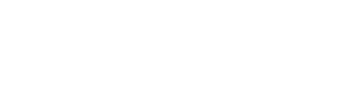

In [0]:
im_013 = get_imgs(slide, levels=[0, 1, 3], width=128, height=128, x=4000, y=5000)

fig, axes = plt.subplots(1, 3, figsize=(6,18))

for i in range(3):
  axes[i].imshow(im_013[..., i*3: (i+1)*3])
  axes[i].axis('off')

In [0]:
def get_patches_coords(slide_path, patch_width=128, patch_height=128, coord_level=3):
    """
    Divide level0 image of a slide into patches, with the specified width and height for each patch. 
    (Default: 128x128 per patch)
    Return an 2D array of strings, of shape (level0_height / patch_height, level0_width / patch_width);
    each string tells the x y coords of the top left point of a patch_lv corresponding to the level0 patch at this position (of the returned 2D array),
    where patch_lv is a (patch_height x patch_width) patch at level $coord_level$ (user specified, default to 3), it is homocentric w.r.t its corresponding level0 patch.  

    :param slide_path: file path to the slide
    :param patch_width, patch_height: default to 128; not recommended to be changed, be careful! - may cause some aliquant issue
    :param coord_level: of which level the x y coordinates in each string represent the top left position of a patch
    :return: 2D array consisting of strings, of shape (level0_height / patch_height, level0_width / patch_width)
    eg. 
    """
    slide = open_slide(slide_path)
    f_name = os.path.basename(slide_path).split('.')[0]

    level0_width = slide.level_dimensions[0][0] 
    level0_height = slide.level_dimensions[0][1]

    if level0_width % patch_width !=0:
        print('Be careful! A level0 image of width {} cannot be divided into integer number of patches given the patch_width: {}'.format(level0_width, patch_width))
    if level0_height % patch_height !=0:
        print('Be careful! A level0 image of height {} cannot be divided into integer number of patches given the patch_height: {}'.format(level0_height, patch_height))
    patch_cols = int(level0_width / patch_width)
    patch_rows = int(level0_height / patch_height)
    result = np.empty((patch_rows, patch_cols), dtype=object)

    for r in range(patch_rows):
        for c in range(patch_cols):
            # coordinates of the top left point at level 0
            x0 = patch_width*c
            y0 = patch_height*r

            # coordinates of the top left point at level $coord_level$
            x = int((x0 - (patch_width*2**coord_level-patch_width)/2) / (2**coord_level))
            y = int((y0 - (patch_height*2**coord_level-patch_height)/2) / (2**coord_level))
            result[r][c] = f_name + '_' + str(x) + '_' + str(y)

    return result


In [0]:
def is_tissue(image, intensity=0.8):
    # print("image shape: ", image.shape)
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    percent_tissue = len(indices[0]) / float(image.shape[0] * image.shape[0]) * 100
    if percent_tissue >= 0.3:
      return True
    else:
      return False

## 016 visualization

In [0]:
im_name = '001'

slide_path = 'tumor_'+ im_name +'.tif' # only this file is available
tumor_mask_path = 'tumor_'+ im_name +'_mask.tif' # only this file is available


slide_url = "https://storage.googleapis.com/dl4cv1445/ADL/tumor_"+ im_name +".tif"
mask_url = "https://storage.googleapis.com/dl4cv1445/ADL/tumor_" + im_name + "_mask.tif"

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [0]:
from numpy import asarray
import time


string_matrix = get_patches_coords(slide_path)
slide = open_slide(slide_path)

output_pred = np.zeros(string_matrix.shape, dtype=np.float32)
heatmap = np.zeros(string_matrix.shape, dtype=np.float32)

start_patch_r = 0
start_patch_c = 0

b_size = 120

patch_rows, patch_cols = string_matrix.shape
print(patch_rows, patch_cols)

steps = int(np.ceil(patch_cols/b_size))
print('overall steps: ', steps * patch_rows)

for i in range(patch_rows):
    test_batch = np.empty((patch_cols, 128, 128, 9), dtype=np.float32)
    for j in range(patch_cols):
        y = int(string_matrix[i+start_patch_r][j+start_patch_c].split('_')[-1])
        x = int(string_matrix[i+start_patch_r][j+start_patch_c].split('_')[-2])
        img = get_imgs(slide, levels=[0, 1, 3], x=x, y=y)
        img = asarray(img, np.float32)
        img /= 255.0

        # fig, axes = plt.subplots(1, 3, figsize=(6,18))
        # for i in range(3):
        #   axes[i].imshow(img[..., i*3: (i+1)*3])
        #   axes[i].axis('off')
        # clear_output(wait=True)
        # time.sleep(1.0)

        # if is_tissue(img[...,0:3]):
        img = tf.expand_dims(img, 0)
        
        test_batch[j,] = img
    print(i, test_batch.shape)
    for k in range(steps):
      if (k+1)*b_size <= patch_cols:
        test_data = test_batch[k*b_size: (k+1)*b_size,]
        temp = model(test_data)
        heatmap[i,...,k*b_size: (k+1)*b_size] = np.squeeze(temp)
      else:
        test_data = test_batch[k*b_size: patch_cols,]
        temp = model(test_data)
        heatmap[i,...,k*b_size: patch_cols] = np.squeeze(temp)
    gc.collect()
 

1728 764
overall steps:  12096
0 (764, 128, 128, 9)
1 (764, 128, 128, 9)
2 (764, 128, 128, 9)
3 (764, 128, 128, 9)
4 (764, 128, 128, 9)
5 (764, 128, 128, 9)
6 (764, 128, 128, 9)
7 (764, 128, 128, 9)
8 (764, 128, 128, 9)
9 (764, 128, 128, 9)
10 (764, 128, 128, 9)
11 (764, 128, 128, 9)
12 (764, 128, 128, 9)
13 (764, 128, 128, 9)
14 (764, 128, 128, 9)
15 (764, 128, 128, 9)
16 (764, 128, 128, 9)
17 (764, 128, 128, 9)
18 (764, 128, 128, 9)
19 (764, 128, 128, 9)
20 (764, 128, 128, 9)
21 (764, 128, 128, 9)
22 (764, 128, 128, 9)
23 (764, 128, 128, 9)
24 (764, 128, 128, 9)
25 (764, 128, 128, 9)
26 (764, 128, 128, 9)
27 (764, 128, 128, 9)
28 (764, 128, 128, 9)
29 (764, 128, 128, 9)
30 (764, 128, 128, 9)
31 (764, 128, 128, 9)
32 (764, 128, 128, 9)
33 (764, 128, 128, 9)
34 (764, 128, 128, 9)
35 (764, 128, 128, 9)
36 (764, 128, 128, 9)
37 (764, 128, 128, 9)
38 (764, 128, 128, 9)
39 (764, 128, 128, 9)
40 (764, 128, 128, 9)
41 (764, 128, 128, 9)
42 (764, 128, 128, 9)
43 (764, 128, 128, 9)
44 (764, 12

In [0]:
np.save(PATH_models+'heatmap_001_all.npy', heatmap)

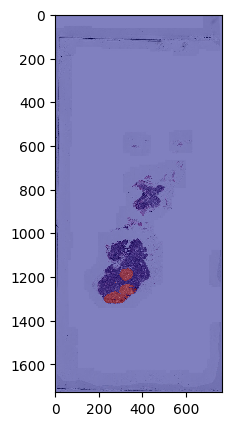

In [0]:


slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:, 0]

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

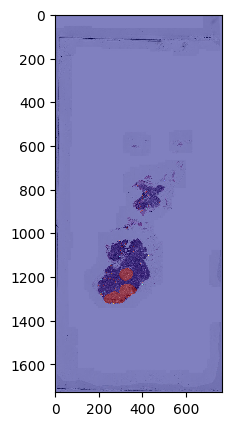

In [0]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])


plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
def recall(mask_image, heatmap):
  TP = 0
  FN = 0
  FP = 0
  TN = 0


  for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
      if mask_image[i][j] >= 0.5 and heatmap[i][j] >= 0.5:
        TP += 1
      elif mask_image[i][j] >= 0.5 and heatmap[i][j] < 0.5:
        FN += 1
      elif mask_image[i][j] < 0.5 and heatmap[i][j] >= 0.5:
        FP += 1
      elif mask_image[i][j] < 0.5 and heatmap[i][j] < 0.5:
        TN += 1

  print('Recall: ', TP * 100.0 / (TP+FN))

In [0]:
recall(mask_image, heatmap)

Recall:  98.90938742228111
